# Validate Models

In [55]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import requests 
import datetime as dt # Converting unix time

# Analysis Libraries

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation
import rasterio
import skgstat as skg # Ordinary kriging interpolation
from scipy import interpolate as interp # Interpolators

# Visualization Libraries

import matplotlib.pyplot as plt # Basic Plotting
import matplotlib as mpl
plt.style.use('ggplot') # 
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

import warnings
warnings.filterwarnings('ignore') # Ignores some warnings

In [8]:
# Definitions

def Save_array_to_geotiff_template(array, template_path, save_path):
    '''Saves a numpy array into a geotiff with the same CRS as the template.
    '''            

    # Get metadata from template
    rst = rasterio.open(template_path) # Open template
    meta = rst.meta.copy() # Copy template metadata
    # meta.update(compress='lzw') # Good for integers/categorical rasters
    rst.close()

    with rasterio.open(save_path, 'w+', **meta) as out: # Burn features into raster
        out.write_band(1, array)

## Load Data

In [9]:
# Load raster template

raster_path = os.path.join(os.getcwd(), '..', '2_Model_Pollutant_Exposure', 'template.npy')

raster = np.load(raster_path)

# Metadata

rst = rasterio.open('../2_Model_Pollutant_Exposure/template.tif') # Open template
meta = rst.meta.copy() # Copy template metadata
# meta.update(compress='lzw') # Good for integers/categorical rasters
rst.close()

# Minneapolis Boundary

mpls_path = os.path.join(os.getcwd(), '..', '1_Data_IO', 'Data', 'mpls_boundary.geojson')
mpls = gpd.read_file(mpls_path)

# PM2.5 Average reading for past half year

# Results are in micrograms/meter^3

path_to_purple_air = os.path.join(os.getcwd(), '..', '1_Data_IO', 'Data', 'pm25_avg.csv')
PurpleAir = pd.read_csv(path_to_purple_air) 

PurpleAir.head(2)

,index,filename,name,is_active,is_outside,is_city,is_B,latitude,longitude,Start_Date,End_Date,Observations,Avg_pm2.5,geometry,EASTING,NORTHING
0,6,Lee Circle (outside) (44.9073 -93.60277) Prima...,Lee Circle,Yes,outside,No,No,44.9073,-93.60277,2021-11-13 00:00:00,2022-10-25 12:00:00,1112.0,0.237451,POINT (452416.0414285391 4972829.227308059),452416.041429,4.972829e+06
1,14,MPCA_Blaine (outside) (45.1407 -93.222) Primar...,MPCA_Blaine,Yes,outside,No,No,45.1407,-93.22200,2021-11-13 00:00:00,2022-10-25 12:00:00,1021.0,6.903046,POINT (482545.9930358104 4998604.378015732),482545.993036,4.998604e+06


In [37]:
# Create spatial purpleair

PurpleAir_geo = gpd.GeoDataFrame(PurpleAir, 
                                 geometry = gpd.points_from_xy(x = PurpleAir.EASTING,
                                                               y = PurpleAir.NORTHING,
                                                               crs = 'EPSG:26915')
                                )

PurpleAir_geo_clipped = gpd.clip(PurpleAir_geo, mpls.buffer(200))

# Drop NAs

PurpleAir = PurpleAir.dropna()

# Get Coordinates 

coords = PurpleAir[['EASTING','NORTHING']].values

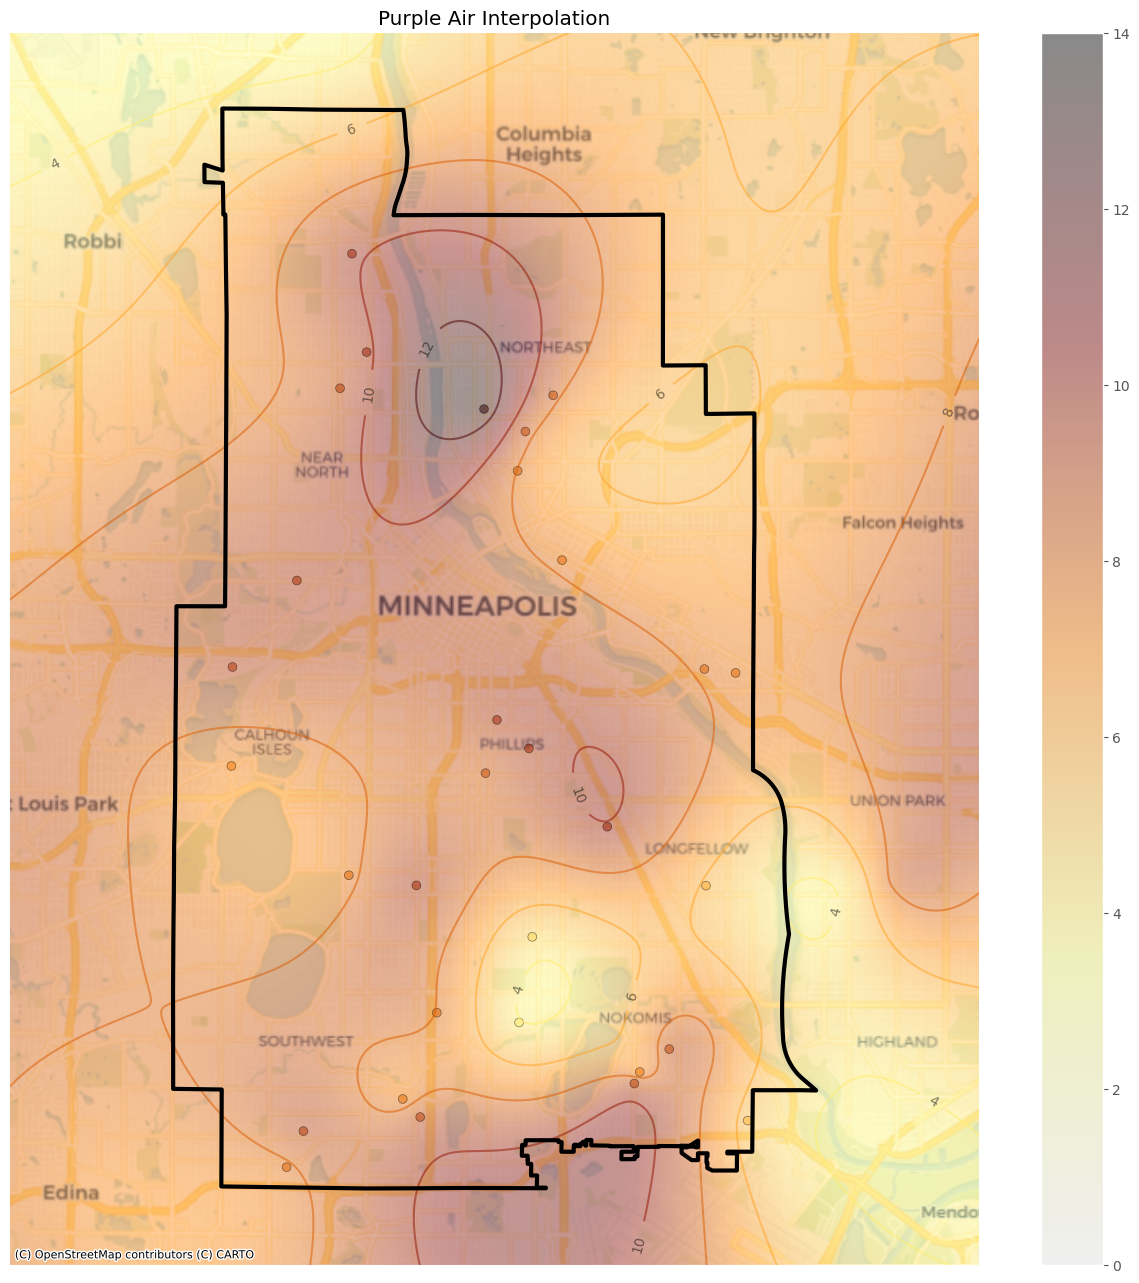

In [64]:
# Interpolate

interpolator = interp.RBFInterpolator(y = coords,
                                      d = PurpleAir['Avg_pm2.5'].values,
                                      kernel = 'thin_plate_spline',
                                     smoothing = .1)
                                      # smoothing = 0.1,
                                      # kernel = 'inverse_quadratic',
                                      # epsilon = .004)
raster_coords = raster.reshape(2, -1).T
            
Z = interpolator(raster_coords).reshape(raster[0].shape)

# PLOT!

norm = mpl.colors.Normalize(vmin=0, vmax=14)

f, ax = plt.subplots(1,1, figsize = (16,16))

art = ax.pcolormesh(raster[0], raster[1], Z, shading='auto', norm = norm, cmap = 'afmhot_r', alpha = 0.4) # Plot interpolation
f.colorbar(art, ax = ax) # Add colorbar
CS = ax.contour(raster[0], raster[1], Z, levels = [0,2,4,6,8,10,12,14], norm = norm, cmap='afmhot_r', alpha = 0.5) # Contours

# This custom formatter removes trailing zeros, e.g. "1.0" becomes "1".

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

# Label contours

ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10, colors = 'black')

title = 'Purple Air Interpolation'
ax.set_title(title) # Add title
ax.set_axis_off()

mpls.plot(ax = ax,
         edgecolor='black', facecolor='none',
         linewidth=3,
         zorder = 2,
         legend = True)

PurpleAir_geo_clipped.plot(column = 'Avg_pm2.5', ax = ax, cmap = 'afmhot_r', 
                           # scheme = 'EqualInterval',
                           # k = 6,
                           alpha = .5,
                           markersize = 40,
               edgecolor = 'black', norm = norm)
                           # legend = True, legend_kwds={'markerscale': 1.5,
                           #                             'fontsize': 'large',
                           #                             'title': 'Observed Avg. PM2.5'})
    
ax.margins(x=-0.2, y=-0.2)
# Add basemap

contextily.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=contextily.providers.CartoDB.Voyager
                      ) 
plt.savefig('Purple Air Interpolation', dpi = 300)
plt.show()

<AxesSubplot: ylabel='Count'>

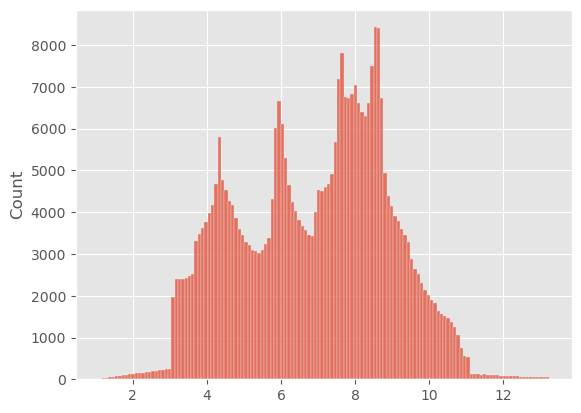

In [6]:
# Check Values

sns.histplot(Z.flatten())

In [10]:
# Alright normalize and move on

Z_norm = Z/Z.max()

<AxesSubplot: ylabel='Count'>

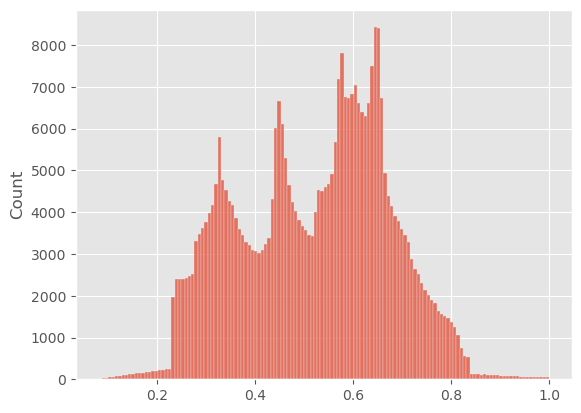

In [11]:
sns.histplot(Z_norm.flatten())

In [13]:
# Save the surface

template_path = os.path.join('..','2_Model_Pollutant_Exposure','template.tif')
save_path = os.path.join('PurpleAir_Interpolation_Normalized.tif')
Save_array_to_geotiff_template(Z_norm, template_path, save_path)